In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
class OptimizedLSTM(nn.Module):

  def __init__(self, input_size, hidden_size,num_layers, output_size,dropout = 0.3):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.input_size = input_size

    # LSTM with dropout between layers
    self.LSTM = nn.LSTM(
        input_size = self.input_size,
        hidden_size = self.hidden_size,
        num_layers = self.num_layers,
        batch_first = True,
        dropout = dropout if num_layers > 1 else 0
        )

    # additional dropout before outptu layer
    self.dropout = nn.Dropout(dropout)

    # output layer
    self.fc = nn.Linear(self.hidden_size, output_size)

  def forward(self,x, hidden):

      output, hidden = self.LSTM(x,hidden)
      output = output.reshape(-1, self.hidden_size)
      output = self.dropout(output)
      output = self.fc(output)
      return output, hidden


  def init_hidden(self, batch_size):
      c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
      h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
      return (h_0, c_0)




class Trainer:

  """
  Training class with all optimizations
  """
  def __init__(self,
      model,
      train_loader,
      val_loader,
      device,
      optimizer_name = 'adamW',
      learning_rate = 0.01,
      weight_decay = 0.01,
      use_scheduler = True,
      early_stopping_patience = 10 ):
    self.model = model.to(device)
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.device = device

    # Loss function
    self.criterion = nn.CrossEntropyLoss()

    # Optimizer selection
    self.optimizer = self._get_optimizer(optimizer_name, learning_rate, weight_decay)

    # Learning Rate Scheduler
    self.scheduler = None
    if use_scheduler:
      self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,mode='min',factor=0.5, patience=10, min_lr=1e-6)


    # early sropping
    self.early_stopping_patience = early_stopping_patience
    self.early_stopping_counter = 0
    self.best_val_loss = float('inf')
    self.best_model_state = None

    # Metrices
    self.train_losses = []
    self.val_losses = []
    self.learning_rates = []

  def _get_optimizer(self, name, lr, weight_decay):
    optimizer = {
        'sgd' : torch.optim.SGD(self.model.parameters(),lr = lr, weight_decay = weight_decay),
        'adam' : torch.optim.Adam(self.model.parameters(),lr = lr,weight_decay = weight_decay),
        'adamw' : torch.optim.AdamW(self.model.parameters(),lr = lr,weight_decay = weight_decay),
        'rmsprop' : torch.optim.RMSprop(self.model.parameters(),lr = lr,weight_decay = weight_decay)
    }

    if name.lower() not in optimizer:
      print(f'Unkown Opimizer {name}, using default AdamW')
      name = 'adamW'

    print(f'Using Optimizer: {name.upper()}')
    return optimizer[name.lower()]


  def train_epoch(self):
    """ Train for one epoch """

    self.model.train()
    total_loss = 0
    num_batches = len(self.train_loader)

    # initialize hidden state
    # size: ( num_layers x batch_size x hidden_size )
    hidden = self.model.init_hidden(self.train_loader.batch_size)
    #print(f'hidden dim: {hidden[0].shape}, {hidden[1].shape}')

    for batch_idx, (sequences,targets) in enumerate(self.train_loader):

      # sequences dim : (batch_size x seq_length)
      # targets dim: (batch_size x seq_length)
      sequences = sequences.to(device)
      #print(f'sequences dim: {sequences.shape}')
      targets = targets.to(device)
      #print(f'targets dim: {targets.shape}')

      # one hot encoding
      # dim: (batch_size x seq_length x input_size)
      oh_seq = torch.nn.functional.one_hot(sequences, num_classes = self.model.input_size).float()
      #print(f'oh_seq dim: {oh_seq.shape}')

      # detach hidden satate
      hidden = tuple([h.detach() for h in hidden])

      # forward pass
      pred, hidden = self.model(oh_seq, hidden) # (batch_size x seq_length x output_size)
      #print(f'pred dim: {pred.shape}')
      loss = self.criterion(pred, targets.view(-1)) # calculate loss
      #print(f'targets.view(-1) dim: {targets.view(-1).shape}')
      #print(f'loss: {loss}')

      # Backward
      self.optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm = 5.0)
      self.optimizer.step()

      # loss from one batch, getting store to calculate total loss across all batches.
      total_loss += loss.item()

    return total_loss / num_batches


  def validate(self):
    """ Validate the model """
    self.model.eval()
    total_loss = 0
    num_batches = len(self.val_loader)

    hidden = self.model.init_hidden(self.val_loader.batch_size)

    with torch.no_grad():
      for sequences, targets in self.val_loader:
        sequences = sequences.to(device)
        targets = targets.to(device)

        oh_seq = torch.nn.functional.one_hot(sequences, num_classes = self.model.input_size).float()

        hidden = tuple([h.detach() for h in hidden])

        pred, hidden = self.model(oh_seq, hidden)
        loss = self.criterion(pred, targets.view(-1))

        total_loss += loss.item()

    return total_loss / num_batches


  def train(self, num_epochs):
    """ Full tainning loop with early stop"""

    print(f"\nStarting training for {num_epochs} epochs...")
    print(f"Device: {self.device}")
    print(f"Early stopping patience: {self.early_stopping_patience}")
    print("-" * 60)

    for epoch in range(num_epochs):

      # Train
      train_loss = self.train_epoch()
      self.train_losses.append(train_loss)

      # Validate
      val_loss = self.validate()
      self.val_losses.append(val_loss)

      # Learning Rate
      current_lr = self.optimizer.param_groups[0]['lr']
      self.learning_rates.append(current_lr)

      # Update scheduler
      if self.scheduler is not None:
        self.scheduler.step(val_loss)


      # Early stopping check
      if val_loss < self.best_val_loss:
        self.best_val_loss = val_loss
        self.patience_counter = 0
        self.best_model_state = copy.deepcopy(self.model.state_dict())
        best_marker = "✓ Best"
      else:
        self.patience_counter += 1
        best_marker = ""


      # Print progress
      print(f"Epoch {epoch+1:3d}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | "
            f"LR: {current_lr:.6f} {best_marker}")

      # Early stopping
      if self.patience_counter >= self.early_stopping_patience:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        print(f"Best validation loss: {self.best_val_loss:.4f}")
        break

    return self.train_losses, self.val_losses


  def plot_training(self, save_path='training_curves.png'):
    """Plot training curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss curves
    ax1.plot(self.train_losses, label='Train Loss', alpha=0.7)
    ax1.plot(self.val_losses, label='Val Loss', alpha=0.7)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Learning rate
    ax2.plot(self.learning_rates, color='orange')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.set_title('Learning Rate Schedule')
    ax2.set_yscale('log')
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    print(f"\nTraining curves saved to {save_path}")

In [10]:
class TextDataset(Dataset):

    def __init__(self, text, seq_length):
        self.text = text
        self.seq_length = seq_length

        # Char to index mapping
        self.chars = sorted(list(set(self.text)))
        self.char_idx = {ch:i for i,ch in enumerate(self.chars)}
        self.idx_char = {i: ch for i, ch in enumerate(self.chars)}
        self.vocab_size = len(self.chars)

        print(f"Vocabulary size: {self.vocab_size}")
        print(f"Unique characters: {self.chars}")

    def __getitem__(self,idx):

        seq = self.text[idx:idx+self.seq_length]
        target = self.text[idx + 1: idx + self.seq_length + 1]

        seq_idx = torch.tensor([self.char_idx[ch] for ch in seq])
        target_idx = torch.tensor([self.char_idx[ch] for ch in target])

        return seq_idx, target_idx


    def __len__(self):
        return len(self.text) - self.seq_length

In [5]:
with open('input.txt', 'r', encoding='utf-8') as f:
        text = f.read()

# Split into train/val (80/20)
split_idx = int(len(text) * 0.8)
train_text = text[:split_idx]
val_text = text[split_idx:]

train_dataset = TextDataset(train_text, seq_length=100)
val_dataset = TextDataset(val_text, seq_length=100)

Vocabulary size: 75
Unique characters: ['\t', '\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocabulary size: 69
Unique characters: ['\t', '\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '1', '3', '5', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [6]:
train_dataset = TextDataset(train_text, seq_length=100)
val_dataset = TextDataset(val_text, seq_length=100)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,drop_last = True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, drop_last = True)

Vocabulary size: 75
Unique characters: ['\t', '\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocabulary size: 69
Unique characters: ['\t', '\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '1', '3', '5', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [7]:
# Model
model = OptimizedLSTM(
    input_size=train_dataset.vocab_size,
    hidden_size=256,
    num_layers=2,
    output_size=train_dataset.vocab_size,
    dropout=0.3)

In [14]:
trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        optimizer_name='adamw',
        learning_rate=0.001,
        weight_decay=0.01,
        use_scheduler=True,
        early_stopping_patience=10
    )

Using Optimizer: ADAMW



Starting training for 100 epochs...
Device: cuda
Early stopping patience: 10
------------------------------------------------------------
Epoch   1/100 | Train Loss: 1.3844 | Val Loss: 8.0553 | LR: 0.001000 ✓ Best
Epoch   2/100 | Train Loss: 1.0044 | Val Loss: 8.6606 | LR: 0.001000 
Epoch   3/100 | Train Loss: 0.8180 | Val Loss: 8.8637 | LR: 0.001000 
Epoch   4/100 | Train Loss: 0.7168 | Val Loss: 8.9137 | LR: 0.001000 
Epoch   5/100 | Train Loss: 0.6550 | Val Loss: 8.6917 | LR: 0.001000 
Epoch   6/100 | Train Loss: 0.6118 | Val Loss: 8.3900 | LR: 0.001000 
Epoch   7/100 | Train Loss: 0.5809 | Val Loss: 8.2577 | LR: 0.001000 
Epoch   8/100 | Train Loss: 0.5559 | Val Loss: 7.9092 | LR: 0.001000 ✓ Best
Epoch   9/100 | Train Loss: 0.5357 | Val Loss: 7.8039 | LR: 0.001000 ✓ Best
Epoch  10/100 | Train Loss: 0.5188 | Val Loss: 7.6662 | LR: 0.001000 ✓ Best
Epoch  11/100 | Train Loss: 0.5045 | Val Loss: 7.4234 | LR: 0.001000 ✓ Best
Epoch  12/100 | Train Loss: 0.4916 | Val Loss: 7.3632 | LR: 0

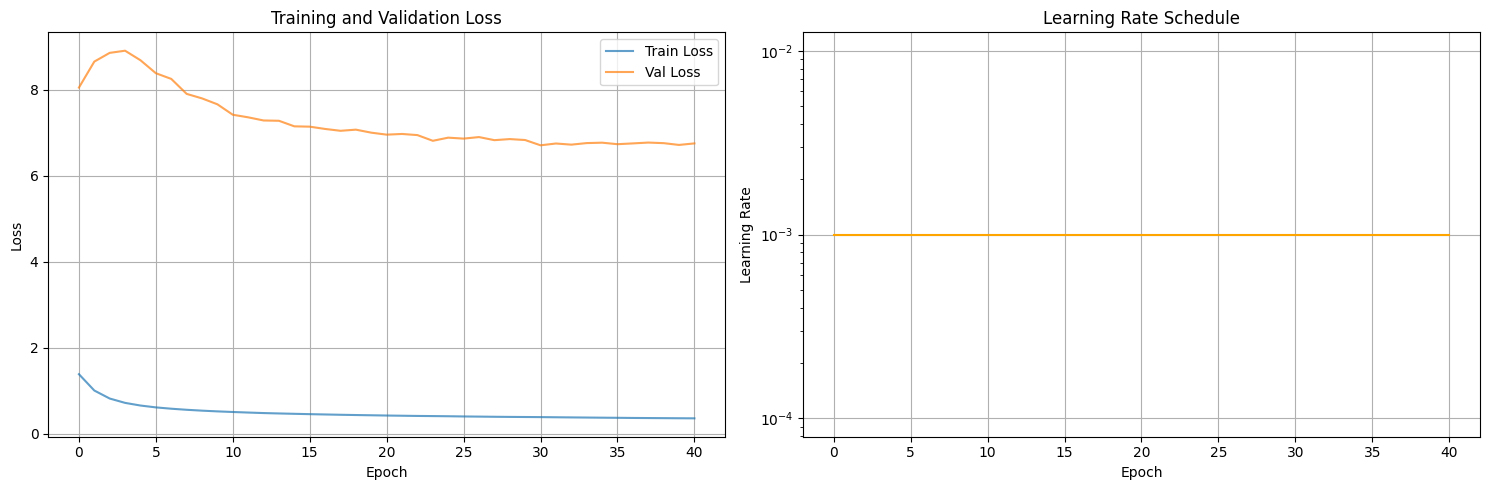

In [15]:
train_losses, val_losses = trainer.train(num_epochs=100)
trainer.plot_training()
torch.save(model.state_dict(), 'optimized_lstm.pth')
print("\nModel saved!")